In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e, m_p
from scipy.signal import fftconvolve

%matplotlib widget
import seaborn as sns
sns.set_context('notebook', font_scale=1.5,
                rc={'lines.markeredgewidth': 1})
sns.set_style('darkgrid', {
        'axes.linewidth': 2,
        'legend.fancybox': True})

## Bunch creation

We create a bunch. No fancy wrapper function available yet to produce a RF matched distribution. A little tedious because it requires quite some definitions to be done beforehand of the full RF System - but that's due to the nature of the problem.

- Some beam kinetic parameters and RF machine parameters

## LHC parameters

In [3]:
p0 = 450e9 * e/c
gamma = np.sqrt((p0/(m_p*c))**2 + 1)
beta = np.sqrt(1 - gamma**-2)

C = 26658.883
R = C/(2*np.pi)
alpha = 3.225e-4
Q_x = 59.31
Q_y = 64.28

eta = alpha - gamma**-2
h1 = 35640
V1 = 8e6
dp = 0 * e/c * C/(beta*c)
Q_s = 2e-3

## Transverse and longitudinal maps

In [4]:
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems, LinearMap

n_segments = 1
s = np.arange(n_segments+1) * C/(n_segments)
alpha_x = 0.*s
alpha_y = 0.*s
beta_x = np.ones(n_segments+1) * R/Q_x
beta_y = np.ones(n_segments+1) * R/Q_y
trans_map = TransverseMap(s=[0, C],
    alpha_x=alpha_x, beta_x=beta_x, D_x=alpha_x,
    alpha_y=alpha_y, beta_y=beta_y, D_y=alpha_y,
    accQ_x=Q_x, accQ_y=Q_y)

long_map = LinearMap([alpha], C, Q_s)
# RFSystems(
#     circumference=C,
#     harmonic_list=h, voltage_list=V, phi_offset_list=dphi, alpha_array=[alpha],
#     gamma_reference=gamma, p_increment=dp, mass=m_p, charge=e)

## Bunch creation

In [5]:
from PyHEADTAIL.trackers.rf_bucket import RFBucket
from PyHEADTAIL.particles.generators import ParticleGenerator, StationaryExponential, generate_Gaussian6DTwiss
from PyHEADTAIL.particles.generators import gaussian2D, longitudinal_linear_matcher, RF_bucket_distribution

epsn_x = 3.75e-6
epsn_y = 3.75e-6
sigma_z = 0.07
eps_geo_z = sigma_z * e/(4*np.pi*p0)

# bunch = ParticleGenerator(
#     macroparticlenumber=1e5, intensity=1e11,
#     charge=e, mass=m_p, gamma=gamma,
#     circumference=C,
#     distribution_x=gaussian2D(epsn_x), alpha_x=0, beta_x=beta_x[0],
#     distribution_y=gaussian2D(epsn_y), alpha_y=0, beta_y=beta_y[0],
#     distribution_z=gaussian2D(eps_geo_z), Qs=0.01, eta=eta).generate()
# #     distribution_z=RF_bucket_distribution(rfbucket, sigma_z=0.23)).generate()

beta_z = eta*R/Q_s
epsn_z = 4*np.pi * sigma_z**2 * p0/(beta_z*e)

bunch = generate_Gaussian6DTwiss(
    macroparticlenumber=int(1e5), intensity=1e11,
    charge=e, gamma=gamma, mass=m_p, circumference=C,
    alpha_x=alpha_x[0], beta_x=beta_x[0], epsn_x=epsn_x,
    alpha_y=alpha_y[0], beta_y=beta_y[0], epsn_y=epsn_y,
    beta_z=beta_z, epsn_z=epsn_z)
    # print ('bunch sigma_z=' + bunch.sigma_z())

bunch_init = copy.copy(bunch)

## Wake fields

In [6]:
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.impedances.wakes import CircularResistiveWall, CircularResonator, WakeField

slicer = UniformBinSlicer(60, z_cuts=(-.1, .1))

wakes = []
wake = CircularResonator(R_shunt=10e6, frequency=1e9, Q=2)
wakes.append(wake.function_transverse(1))
wake = CircularResistiveWall(pipe_radius=5e-2, resistive_wall_length=C*.9, conductivity=3e9, dt_min=1e-3/c, beta=bunch.beta)
wakes.append(wake.function_transverse(1))

wakefields = WakeField(slicer, wake)

slices = bunch.get_slices(slicer)

[-0.09833333 -0.095      -0.09166667 -0.08833333 -0.085      -0.08166667
 -0.07833333 -0.075      -0.07166667 -0.06833333 -0.065      -0.06166667
 -0.05833333 -0.055      -0.05166667 -0.04833333 -0.045      -0.04166667
 -0.03833333 -0.035      -0.03166667 -0.02833333 -0.025      -0.02166667
 -0.01833333 -0.015      -0.01166667 -0.00833333 -0.005      -0.00166667
  0.00166667  0.005       0.00833333  0.01166667  0.015       0.01833333
  0.02166667  0.025       0.02833333  0.03166667  0.035       0.03833333
  0.04166667  0.045       0.04833333  0.05166667  0.055       0.05833333
  0.06166667  0.065       0.06833333  0.07166667  0.075       0.07833333
  0.08166667  0.085       0.08833333  0.09166667  0.095       0.09833333]


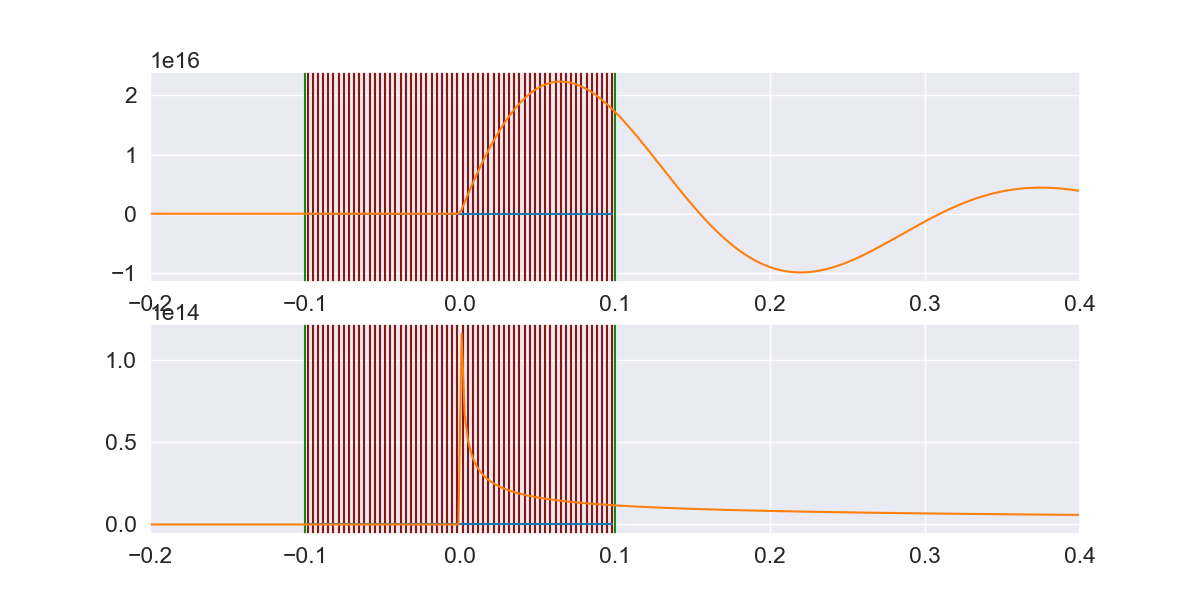

In [7]:
col = sns.hls_palette(6, l=.3, s=.8)

fig, axes = plt.subplots(2, figsize=(12,6))

zz = slices.z_centers
print(zz)
tt = zz/(bunch.beta*c)
t0 = np.concatenate((tt-tt[-1], (tt-tt[0])[1:]))
t0 = np.linspace(-1, 1, 1000)/(bunch.beta*c)

for i, wk in enumerate(wakes):
    [axes[i].axvline(s, c=col[0]) for s in zz]
    [axes[i].axvline(s, c=col[2]) for s in [slices.z_cut_tail, slices.z_cut_head]]
    axes[i].plot(zz, slices.charge_per_slice/max(slices.charge_per_slice), '-')
    axes[i].plot(t0*bunch.beta*c, -wk(t0, beta=bunch.beta)[::-1], '-')
    axes[i].set_xlim(-.2, 0.4)

plt.show()

## Tracking loop
***

In [8]:
one_turn_map = [m for m in trans_map] + [long_map] + [wakefields]

In [9]:
bunch = copy.copy(bunch_init)

plt.close('all')
plt.ion()
fig, axes = plt.subplots(3, figsize=(16, 10))

nturns = 1000
turns = np.arange(nturns)
mean_z = 0.*turns
mean_dp = 0.*turns
sigma_z = 0.*turns
epsn_z = 0.*turns
for i in range(nturns):
    for m in one_turn_map:
        m.track(bunch)

    mean_z[i] = bunch.mean_z()
    mean_dp[i] = bunch.mean_dp()
    sigma_z[i] = bunch.sigma_z()
    epsn_z[i] = bunch.epsn_z()
    '''
    if i%10==0:
        axes[0].plot(bunch.x[::10], bunch.xp[::10]*100, '.')
        axes[1].plot(bunch.y[::10], bunch.yp[::10]*100, '.')
        axes[2].plot(bunch.z[::10], bunch.dp[::10]*1000, '.')
        axes[0].set_xlim(-4e-2, 4e-2)
        axes[0].set_ylim(-4e-2, 4e-2)
        axes[1].set_xlim(-4e-2, 4e-2)
        axes[1].set_ylim(-4e-2, 4e-2)
        axes[2].set_xlim(-0.6, 0.6)
        axes[2].set_ylim(-0.6, 0.6)
        plt.pause(0.1)
        plt.draw()
        [ax.cla() for ax in axes]
    '''

plt.ioff()
plt.close('all')

## Backup

No such comm: e2b95714bb4e4010a1252ae52fd8b8d6


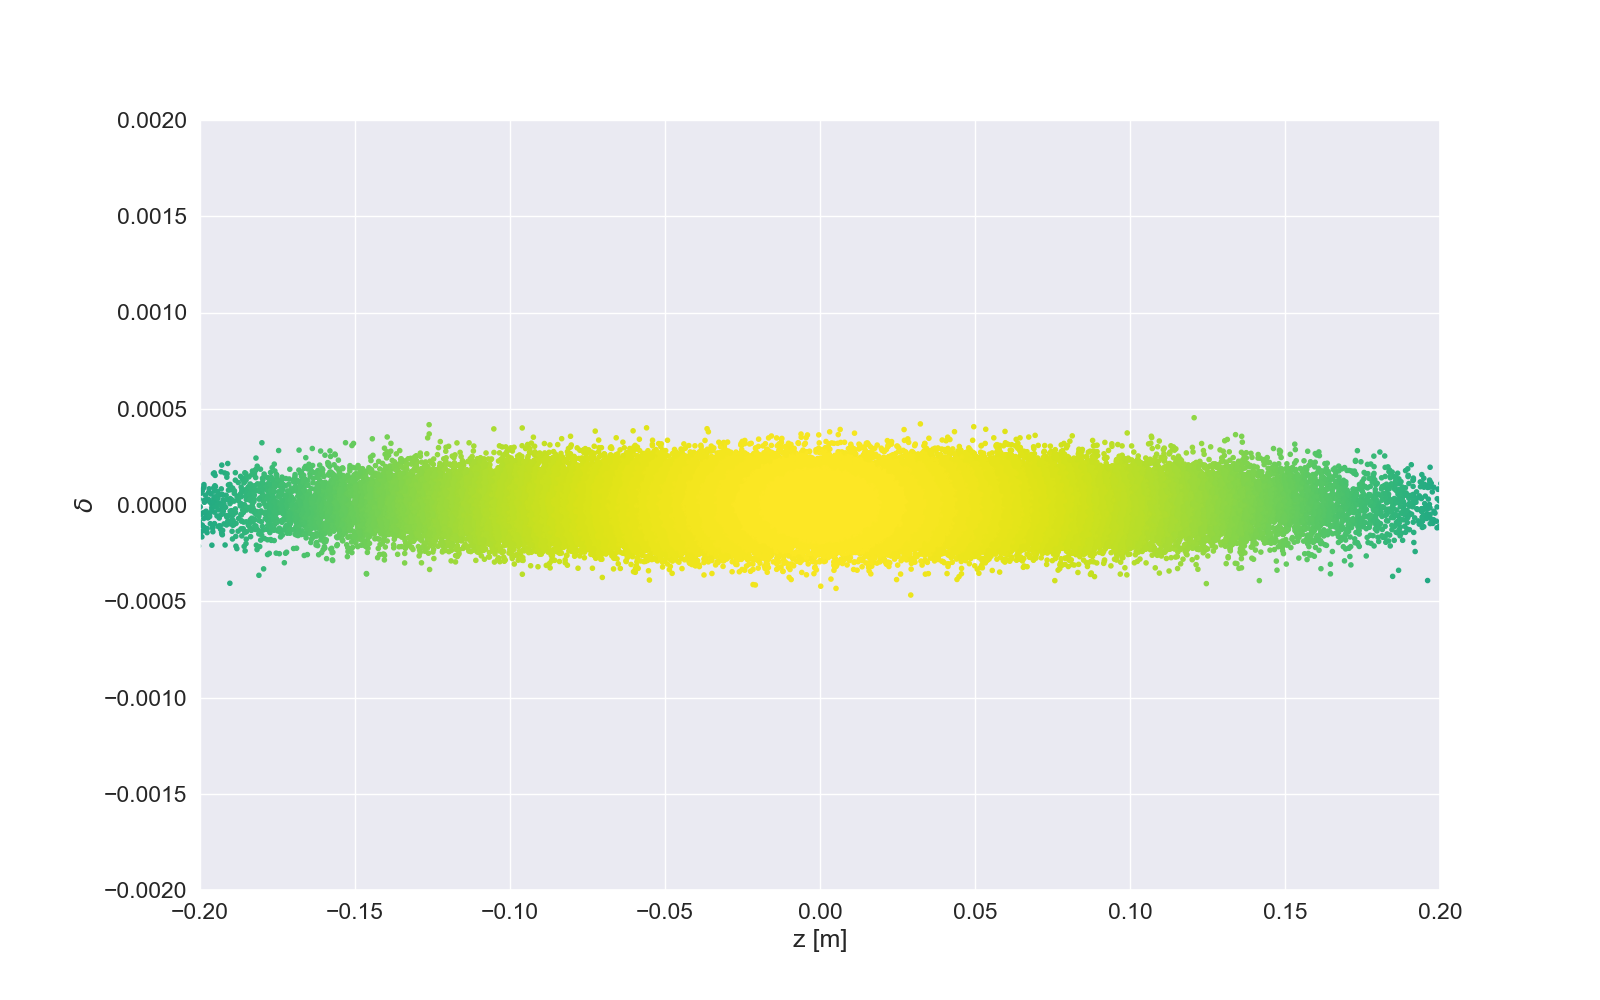

No such comm: 87c6fa1b0b554670b48aa845d9df1850


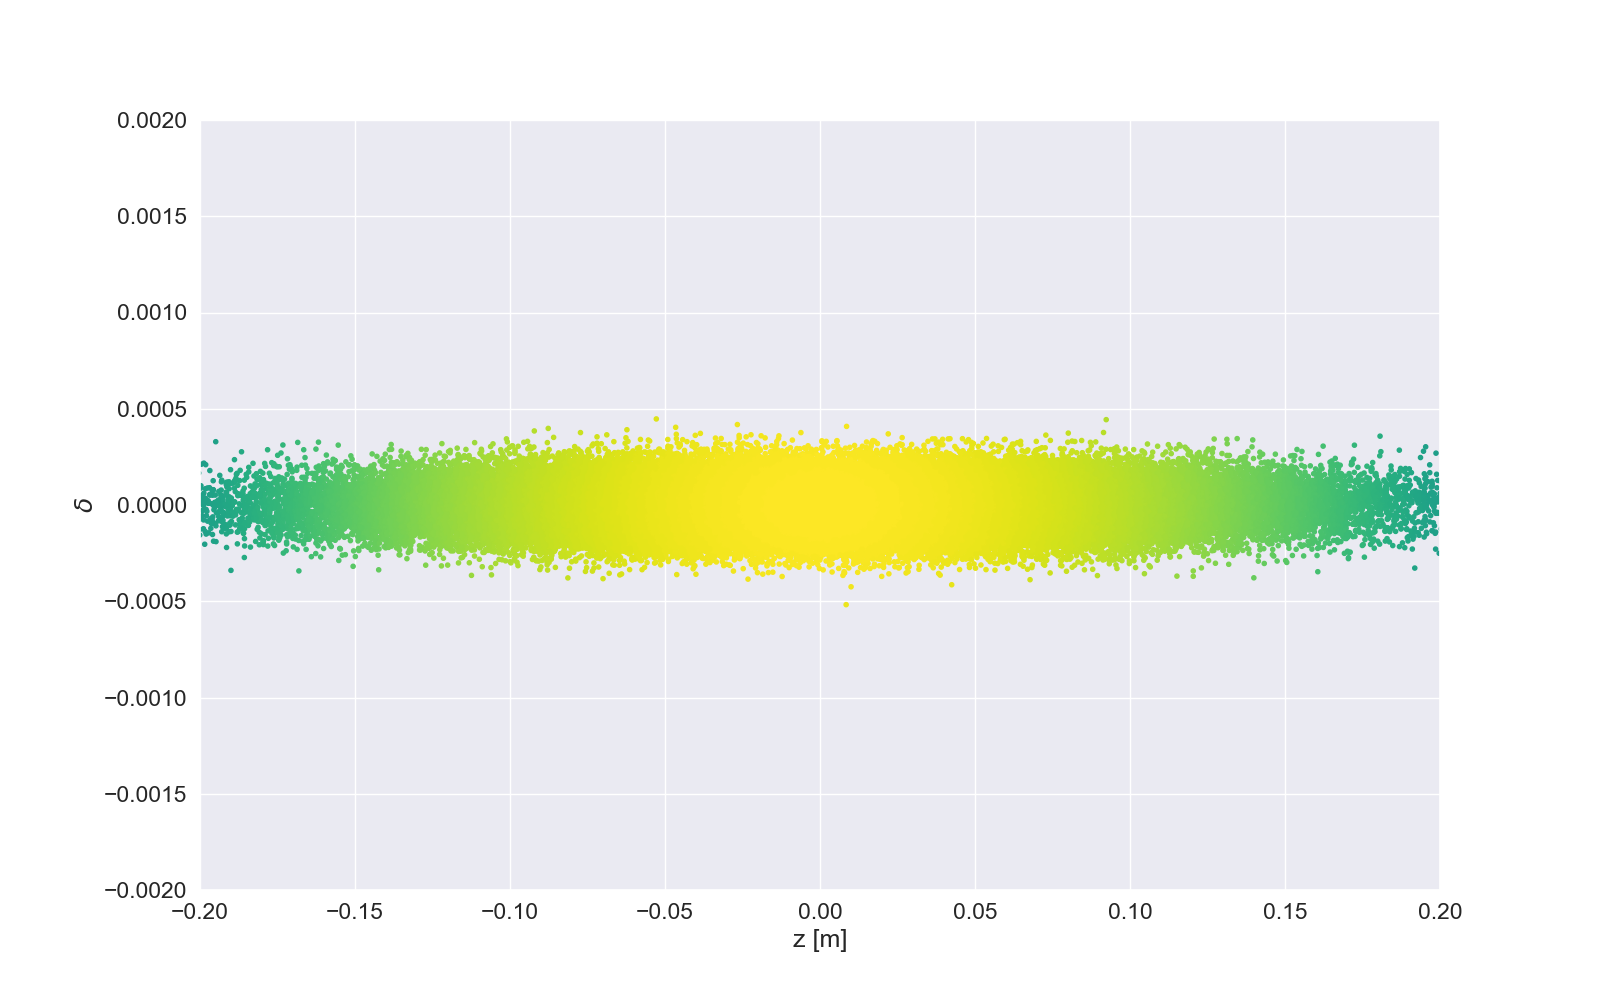

In [10]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
zz = np.linspace(-.8, .8, 1000)
hh = bunch.z**2 + (100*bunch.dp)**2
# hh = rfbucket.hamiltonian(bunch.z, bunch.dp)
# ss = rfbucket.separatrix(zz)

# ax1.plot(zz, +ss, c='orange', lw=2)
# ax1.plot(zz, -ss, c='orange', lw=2)
ax1.scatter(bunch.z, bunch.dp, c=hh, marker='.', cmap=plt.cm.viridis_r)
ax1.set_xlim(-.2, .2)
ax1.set_ylim(-2e-3, 2e-3)
plt.xlabel("z [m]")
plt.ylabel(r"$\delta$")
plt.show()

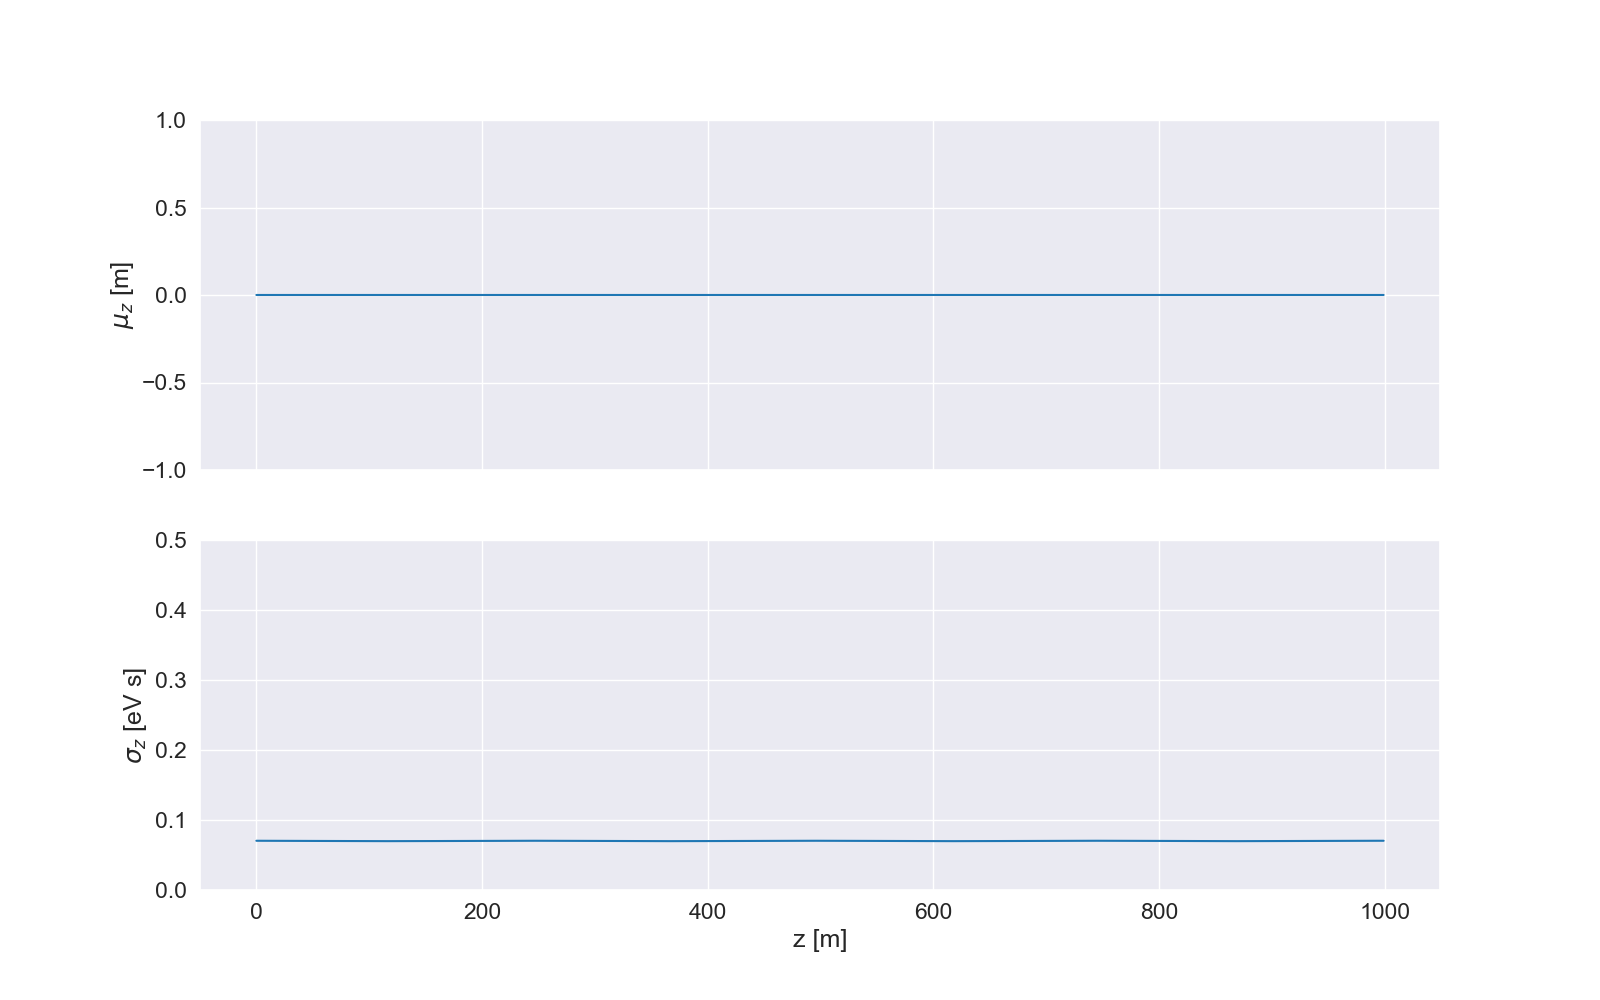

In [11]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16,10), sharex=True)

ax1.plot(turns, mean_z)
ax1.set_ylabel(r"$\mu_z$ [m]")
ax1.set_ylim(-1, 1)
ax2.plot(turns, sigma_z)
ax2.set_xlabel("z [m]")
ax2.set_ylabel(r"$\sigma_z$ [eV s]")
ax2.set_ylim(0, 0.5)

plt.show()

In [12]:
import sys, os
BIN = os.path.expanduser("../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
plt.switch_backend('TkAgg')

import copy

from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.impedances.wakes import WakeField, WakeTable, Resonator, CircularResonator, ParallelPlatesResonator
from PyHEADTAIL.impedances.wakes import ResistiveWall, CircularResistiveWall, ParallelPlatesResistiveWall
from PyHEADTAIL.trackers.longitudinal_tracking import LinearMap
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.particles.slicing import UniformBinSlicer, UniformChargeSlicer
from PyHEADTAIL.general.printers import SilentPrinter

def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):

    intensity = 1.05e11
    sigma_z = 0.059958
    #gamma = 3730.26
    gamma = 450e9/940e6
    #gamma = 3e12/940e6
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference /
              (2 * np.pi * linear_map.Q_s))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e)

    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    # print ('bunch sigma_z=' + bunch.sigma_z())

    return bunch

def realtime_bunch_plot(bunch,fig,axX,axY,axZ,bunch0,range_multiplier):

    sigma0_x=bunch0.sigma_x()
    sigma0_xp=bunch0.sigma_xp()
    sigma0_y=bunch0.sigma_y()
    sigma0_yp=bunch0.sigma_yp()
    sigma0_z=bunch0.sigma_z()
    sigma0_dp=bunch0.sigma_dp()


    axX.cla()
    axX.set_autoscale_on(False)
    axX.set_xlim([-1*range_multiplier*sigma0_x, range_multiplier*sigma0_x])
    axX.set_ylim([-1*range_multiplier*sigma0_xp, range_multiplier*sigma0_xp])
    axX.set_xlabel("X")
    axX.set_ylabel("Xp")
    axX.scatter(bunch.x, bunch.xp)


    axY.cla()
    axX.set_autoscale_on(False)
    axY.scatter(bunch.y, bunch.yp)
    axY.set_xlim([-1*range_multiplier*sigma0_y, range_multiplier*sigma0_y])
    axY.set_ylim([-1*range_multiplier*sigma0_yp, range_multiplier*sigma0_yp])
    axY.set_xlabel("Y")
    axY.set_ylabel("Yp")


    axZ.cla()
    axX.set_autoscale_on(True)
    axZ.scatter(bunch.z, bunch.dp)
    axZ.set_xlim([-1*range_multiplier*sigma0_z, range_multiplier*sigma0_z])
    axZ.set_ylim([-1*range_multiplier*sigma0_dp, range_multiplier*sigma0_dp])
    axY.set_xlabel("Z")
    axY.set_ylabel("dP")

    fig.canvas.draw()

# Basic parameters.
n_turns = 1000
n_segments = 1
n_macroparticles = 100000

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
alpha_0 = [0.0003225]

# Parameters for transverse map.
s = np.arange(0, n_segments + 1) * C / n_segments

alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
D_x = np.zeros(n_segments)

alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)
D_y = np.zeros(n_segments)

# CASE TEST SETUP

ampl_det = AmplitudeDetuning.from_octupole_currents_LHC(i_focusing=200, i_defocusing=-200)
chroma = Chromaticity(Qp_x=6, Qp_y=10)

#trans_map = TransverseMap(
#    s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y, (ampl_det, chroma))

trans_map = TransverseMap(
    s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y)

long_map = LinearMap(alpha_0, C, Q_s)

bunch = generate_bunch(
    n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,
    long_map)

n_sigma_z = 2
n_slices = 300
uniform_bin_slicer= UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

# Definition of WakeField as a composition of different sources.
resis_circ = CircularResistiveWall(pipe_radius=5e-2, resistive_wall_length=C,
                                    conductivity=3e10, dt_min=1e-3/c)
wake_field = WakeField(uniform_bin_slicer, resis_circ)
for i in wake_field.wake_kicks:
    print(i)

trans_map = [ m for m in trans_map ]
map_woWakes = trans_map + [long_map]

#Initialization of real time plot
plt.ion()
realTimeFig = plt.figure(figsize=(8, 8))
realTimeAx1 = realTimeFig.add_subplot(311)
realTimeAx2 = realTimeFig.add_subplot(312)
realTimeAx3 = realTimeFig.add_subplot(313)
realTimeFig.show()

realTimeFig_noFB = plt.figure(figsize=(8, 8))
realTimeAx1_noFB = realTimeFig_noFB.add_subplot(311)
realTimeAx2_noFB = realTimeFig_noFB.add_subplot(312)
realTimeAx3_noFB = realTimeFig_noFB.add_subplot(313)
realTimeFig_noFB.show()



counter = 0 #turn counter
plotEveryNturn = 10

gain=0.30

#bunch.x += 0.001
#bunch.y += 0.001

bunch_noFB = copy.copy(bunch)
bunch0 = copy.copy(bunch)

mean_x = np.empty(n_turns)
mean_xp = np.empty(n_turns)
mean_y = np.empty(n_turns)
mean_yp = np.empty(n_turns)
mean_z = np.empty(n_turns)
mean_dp = np.empty(n_turns)

sigma_x = np.empty(n_turns)
sigma_y = np.empty(n_turns)
sigma_z = np.empty(n_turns)

eps_x = np.empty(n_turns)
eps_y = np.empty(n_turns)
eps_z = np.empty(n_turns)

mean_x_noFB = np.empty(n_turns)
mean_xp_noFB = np.empty(n_turns)
mean_y_noFB = np.empty(n_turns)
mean_yp_noFB = np.empty(n_turns)
mean_z_noFB = np.empty(n_turns)
mean_dp_noFB = np.empty(n_turns)

sigma_x_noFB = np.empty(n_turns)
sigma_y_noFB = np.empty(n_turns)
sigma_z_noFB = np.empty(n_turns)

eps_x_noFB = np.empty(n_turns)
eps_y_noFB = np.empty(n_turns)
eps_z_noFB = np.empty(n_turns)

sigma_x0=bunch.sigma_x()
sigma_y0=bunch.sigma_y()
eps_x0=bunch.epsn_x()
eps_y0=bunch.epsn_y()

for i in range(n_turns):
    for m_ in map_woWakes:
        m_.track(bunch)
        m_.track(bunch_noFB)

    wake_field.track(bunch)
    wake_field.track(bunch_noFB)
        #real time plot
    counter = counter + 1

    if counter == plotEveryNturn:
        print("Turn: %d" % i)
        counter = 0
        realtime_bunch_plot(bunch,realTimeFig,realTimeAx1,realTimeAx2,realTimeAx3,bunch0,10)
        realtime_bunch_plot(bunch_noFB,realTimeFig_noFB,realTimeAx1_noFB,realTimeAx2_noFB,realTimeAx3_noFB,bunch0,10)

    #recording data
    mean_x[i] = bunch.mean_x()
    mean_xp[i] = bunch.mean_xp()
    mean_y[i] = bunch.mean_y()
    mean_yp[i] = bunch.mean_yp()
    mean_z[i] = bunch.mean_z()
    mean_dp[i] = bunch.mean_dp()
    sigma_x[i] = bunch.sigma_x()
    sigma_y[i] = bunch.sigma_y()
    sigma_z[i] = bunch.sigma_z()

    eps_x[i] = bunch.epsn_x()
    eps_y[i] = bunch.epsn_y()
    eps_z[i] = bunch.epsn_z()

    mean_x_noFB[i] = bunch_noFB.mean_x()
    mean_xp_noFB[i] = bunch_noFB.mean_xp()
    mean_y_noFB[i] = bunch_noFB.mean_y()
    mean_yp_noFB[i] = bunch_noFB.mean_yp()
    mean_z_noFB[i] = bunch_noFB.mean_z()
    mean_dp_noFB[i] = bunch_noFB.mean_dp()

    sigma_x_noFB[i] = bunch_noFB.sigma_x()
    sigma_y_noFB[i] = bunch_noFB.sigma_y()
    sigma_z_noFB[i] = bunch_noFB.sigma_z()

    eps_x_noFB[i] = bunch_noFB.epsn_x()
    eps_y_noFB[i] = bunch_noFB.epsn_y()
    eps_z_noFB[i] = bunch_noFB.epsn_z()

    #self made damper
    bunch.xp -= gain*bunch.mean_xp()
    bunch.yp -= gain*bunch.mean_yp()


fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)
ax4 = fig.add_subplot(614)
ax5 = fig.add_subplot(615)
ax6 = fig.add_subplot(616)

ax1.plot(mean_x_noFB, '-', c='k')
ax1.plot(mean_x, '-', c='b')
ax1.set_xlabel('turns')
ax1.set_ylabel('mean x')
ax1.set_ylim(-5*sigma_x0, 5*sigma_x0)

ax2.plot(mean_y_noFB, '-', c='k')
ax2.plot(mean_y, '-', c='r')
ax2.set_xlabel('turns')
ax2.set_ylabel('mean y')
ax2.set_ylim(-5*sigma_y0, 5*sigma_y0)

ax3.plot(mean_z_noFB, '-', c='k')
ax3.plot(mean_z, '-', c='g')
ax3.set_xlabel('turns')
ax3.set_ylabel('mean z')

ax4.plot(sigma_x_noFB, '-', c='k')
ax4.plot(sigma_x, '-', c='b')
ax4.set_xlabel('turns')
ax4.set_ylabel('sigma x')
ax4.set_ylim(0, 5*sigma_x0)

ax5.plot(sigma_y_noFB, '-', c='k')
ax5.plot(sigma_y, '-', c='r')
ax5.set_xlabel('turns')
ax5.set_ylabel('sigma y')
ax5.set_ylim(0, 5*sigma_y0)

ax6.plot(sigma_z_noFB, '-', c='k')
ax6.plot(sigma_z, '-', c='g')
ax6.set_xlabel('turns')
ax6.set_ylabel('sigma z')

fig.canvas.draw()


figEps = plt.figure(figsize=(8,8))
ax1Eps = figEps.add_subplot(211)
ax2Eps = figEps.add_subplot(212)

ax1Eps.plot(eps_x_noFB, '-', c='k')
ax1Eps.plot(eps_x, '-', c='b')
ax1Eps.set_xlabel('turns')
ax1Eps.set_ylabel('eps x')
ax1Eps.set_ylim(0, 10*eps_x0)

ax2Eps.plot(eps_y_noFB, '-', c='k')
ax2Eps.plot(eps_y, '-', c='r')
ax2Eps.set_xlabel('turns')
ax2Eps.set_ylabel('eps y')
ax2Eps.set_ylim(0, 10*eps_y0)

figEps.canvas.draw()

raw_input()


Turn: 9
Turn: 19
Turn: 29
Turn: 39
Turn: 49
Turn: 59
Turn: 69
Turn: 79
Turn: 89
Turn: 99
Turn: 109
Turn: 119
Turn: 129
Turn: 139
Turn: 149
Turn: 159
Turn: 169
Turn: 179
Turn: 189
Turn: 199
Turn: 209
Turn: 219
Turn: 229
Turn: 239
Turn: 249
Turn: 259
Turn: 269
Turn: 279
Turn: 289
Turn: 299
Turn: 309
Turn: 319
Turn: 329
Turn: 339
Turn: 349
Turn: 359
Turn: 369
Turn: 379
Turn: 389
Turn: 399
Turn: 409
Turn: 419
Turn: 429
Turn: 439
Turn: 449
Turn: 459
Turn: 469
Turn: 479
Turn: 489
Turn: 499
Turn: 509
Turn: 519
Turn: 529
Turn: 539
Turn: 549
Turn: 559
Turn: 569
Turn: 579
Turn: 589
Turn: 599
Turn: 609
Turn: 619
Turn: 629
Turn: 639
Turn: 649
Turn: 659
Turn: 669
Turn: 679
Turn: 689
Turn: 699
Turn: 709
Turn: 719
Turn: 729
Turn: 739
Turn: 749
Turn: 759
Turn: 769
Turn: 779
Turn: 789
Turn: 799
Turn: 809
Turn: 819
Turn: 829
Turn: 839
Turn: 849
Turn: 859
Turn: 869
Turn: 879
Turn: 889
Turn: 899
Turn: 909
Turn: 919
Turn: 929
Turn: 939
Turn: 949
Turn: 959
Turn: 969
Turn: 979
Turn: 989
Turn: 999


NameError: name 'raw_input' is not defined

In [ ]:
rfbucket = RFBucket(
    charge=e, mass=m_p, gamma=gamma,
    circumference=C,
    alpha_array=[alpha], p_increment=dp,
    harmonic_list=[h1], voltage_list=[V1], phi_offset_list=[0])

## Convolutions

In [ ]:
def convolution_python(t_target, t_source, c_source, w):
    dxp = 0.*t_target
    for k in xrange(len(t_target)):
        for l in xrange(len(t_source)):
            dxp[k] += c_source[l]*w(t_target[k]-t_source[l])

    return dxp

In [ ]:
def convolution_numpy(t_target, t_source, c_source, w):
    tmin, tmax = t_source[0], t_source[-1]
    tt = np.concatenate((t_target-tmax, (t_target-tmin)[1:]))
    
    return np.convolve(c_source, w(tt), mode='valid')

In [ ]:
def convolution_scipy(t, x, w):
    tmin, tmax = t[0], t[-1]
    tt = np.concatenate((t-tmax, (t-tmin)[1:]))
    
    return fftconvolve(w(tt), x, mode='valid')

In [ ]:
def convolution_multibunch_numpy(times, moments, wf, dt):
    
    dxp = []
    if dt is None: dt = 0.*np.array(times)
    for i in xrange(len(times)):
        z = 0.*times[i]
        t_target = times[i]
        for j in range(i+1):
            t_source = times[j] + dt[i] - dt[j]
            c_source = moments[j]
            z += convolution_numpy(t_target, t_source, c_source, wf)
            
        dxp.append(z)
        
    return dxp

In [ ]:
def convolution_multibunch_numpy(times, cmoments, wf, dt):
    dts = times[i]
    t0 = np.concatenate((dts-dts[-1], (dts-dts[0])[1:]))

    dxp = np.convolve(s.charge_per_slice, wf(t0))
    dxp_s = np.convolve(s.charge_per_slice, wf(t0), mode='same')
    dxp_v = np.convolve(s.charge_per_slice, wf(t0), mode='valid')

    for j in range(i):
        print(i, j, dt[i-j])
        t_sources = times[j] + dt[i]-dt[j]
        t2 = np.concatenate((dts-t_sources[-1], (dts-t_sources[0])[1:]))

        dxp += np.convolve(slices[j].charge_per_slice, wf(t2))
        dxp_s += np.convolve(slices[j].charge_per_slice, wf(t2), mode='same')
        dxp_v += np.convolve(slices[j].charge_per_slice, wf(t2), mode='valid')
    
    dxp_list.append(dxp_v)

In [ ]:
def convolve_multibunch(times, moments, wf, dt=None):
    dxp = []
    if dt is None: dt = 0.*np.array(times)
    for i in xrange(len(times)):
        z = 0.*times[i]
        t_target = times[i]
        for j in range(i+1):
            t_source = times[j] + dt[i] - dt[j]
            c_source = moments[j]
            z += convolution_python(t_target, t_source, c_source, wf)
            
        dxp.append(z)
        
    return dxp

In [ ]:
plt.close('all')